In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


# 1. Gaussian mixture state-space model

We consider a simple one-dimensional Gaussian mixture state process:
\begin{align*}
    y_i|\mathbf{\theta}, w_i &\sim w_i \mathcal{N}(\mu_1, \sigma_{1}^2) + (1-w_i) \mathcal{N}(\mu_{2}, \sigma_{2}^2),\: i=2,\dots, N,\\
    w_i|p &\sim \text{Bernoulli}(p), \: i=1, 2, \dots, N,
\end{align*}

where $p \in [0,1]$ denotes the probability of selecting each of the mixture components. The model parameters are $\mathbf{\theta} = (p, \mu_1, \mu_2, \sigma_{1}^2, \sigma_{2}^2)$.

In [2]:
# simulator
def gaussian_mixture(theta: torch.Tensor, N=100) -> torch.Tensor:
    '''
    Simulates from a Gaussian mixture  model
    '''
    # define Gaussian mixture
    probs = torch.cat((theta[...,0], 1-theta[...,0]), dim=-1)
    mix = D.Categorical(probs=probs)
    comp = D.Normal(loc=theta[...,1:3].squeeze(),
                 scale=torch.sqrt(theta[...,3:5].squeeze()))
    
    gmm = D.MixtureSameFamily(mix, comp)
    
    # simulate data
    y = gmm.sample((N,))
    
    return y

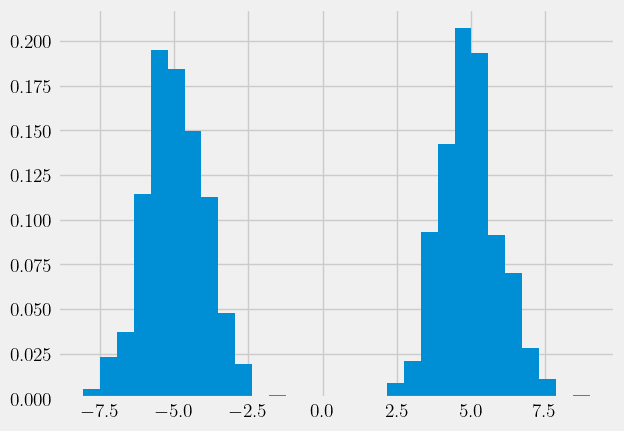

In [3]:
# model 1
theta = torch.tensor([[0.5, -5.0, 5.0, 1.0, 1.0]])
N = 1000

y = gaussian_mixture(theta, N)

plt.hist(y, bins=30, density=True);

# 1.2. Parameter priors

\begin{align*}
    p &\sim U(0,1),\\
    \mu_1 &\sim \mathcal{N}(-5, 4),\\
    \mu_2 &\sim \mathcal{N}(5, 4),\\
    \sigma_{_1}^2 &\sim \Gamma^{-1}(2,2),\\
    \sigma_{2}^2 &\sim \Gamma^{-1}(2, 2)\\
\end{align*}

In [4]:
class Prior():
    def __init__(self, params_p, params_mu_1, params_mu_2, params_sigma2_1, params_sigma2_2):
        
        self.p = D.Uniform(low=params_p['lower'], high=params_p['upper'])

        self.mu1 = D.Normal(loc=params_mu_1['mu'], scale=params_mu_1['sigma'])
        
        self.mu2 = D.Normal(loc=params_mu_2['mu'], scale=params_mu_2['sigma'])

        self.sigma2_1 = D.InverseGamma(params_sigma2_1['alpha'], params_sigma2_1['beta'])
        
        self.sigma2_2 = D.InverseGamma(params_sigma2_2['alpha'], params_sigma2_2['beta'])
        
    def sample(self, shape: torch.Size = ()):
        theta = torch.stack([self.p.sample(shape),
                             self.mu1.sample(shape),
                             self.mu2.sample(shape),
                             self.sigma2_1.sample(shape),
                             self.sigma2_2.sample(shape)
                            ], dim=-1)       
        
        return theta

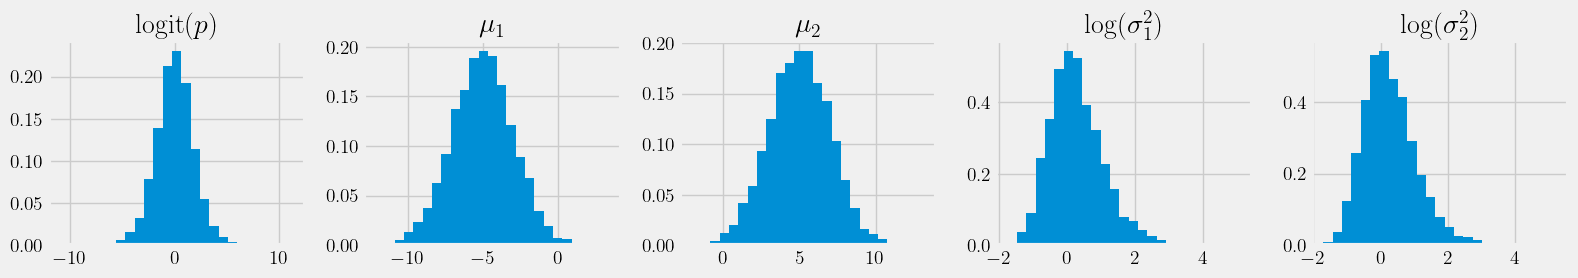

In [5]:
p = {'lower': 0.0, 'upper': 1.0}
mu_1 = {'mu': -5.0, 'sigma': 2.0}
mu_2 = {'mu': 5.0, 'sigma': 2.0}
sigma2_1 = {'alpha': 2.0, 'beta': 2.0}
sigma2_2 = {'alpha': 2.0, 'beta': 2.0}

prior = Prior(p, mu_1, mu_2, sigma2_1, sigma2_2)
N = 5000
theta =  prior.sample((N,))

fig = plt.figure(figsize=(16, 3))

fig.add_subplot(151)
plt.hist(theta[...,0].logit(), bins=25, density=True)
plt.title(r'$\mathrm{logit}(p)$')

fig.add_subplot(152)
plt.hist(theta[...,1], bins=25, density=True)
plt.title(r'$\mu_1$')

fig.add_subplot(153)
plt.hist(theta[...,2], bins=25, density=True)
plt.title(r'$\mu_2$')

fig.add_subplot(154)
plt.hist(theta[...,3].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{1}^2) $')

fig.add_subplot(155)
plt.hist(theta[...,4].log(), bins=25, density=True)
plt.title(r'$\log(\sigma_{2}^2) $')

plt.tight_layout()
plt.show()

## 3. Neural Varitional inference: Training the Neural Net

### Training

In [216]:
torch.logit(torch.tensor([0.5]))

tensor([0.])

Epoch 1 Loss 10.797440471076966 

Epoch 2 Loss 7.408606159448624 

Epoch 3 Loss 6.34710015091896 

Epoch 4 Loss 5.297050861704349 

Epoch 5 Loss 4.034767017219996 

Epoch 6 Loss 3.3713553598181343 

Epoch 7 Loss 2.654131127438441 

Epoch 8 Loss 2.1471563545726937 

Epoch 9 Loss 1.9575900092111203 

Epoch 10 Loss 1.646629777691199 

Epoch 11 Loss 1.2943642343251442 

Epoch 12 Loss 1.0525370964995353 

Epoch 13 Loss 1.1052020554700401 

Epoch 14 Loss 0.8256858804950956 

Epoch 15 Loss 0.7816231289650081 

Epoch 16 Loss 0.6160200370043516 

Epoch 17 Loss 0.5177818084946135 

Epoch 18 Loss 0.5148690358519067 

Epoch 19 Loss 0.29833581401401027 

Epoch 20 Loss 0.23884806419012602 

Epoch 21 Loss 0.21102546394432428 

Epoch 22 Loss 0.2465531371630961 

Epoch 23 Loss 0.15969982214970513 

Epoch 24 Loss 0.008398924693604929 

Epoch 25 Loss -0.04781410735715472 

Epoch 26 Loss -0.09791213713660836 

Epoch 27 Loss -0.15151528136234266 

Epoch 28 Loss -0.060900513637322004 

Epoch 29 Loss -0.1135

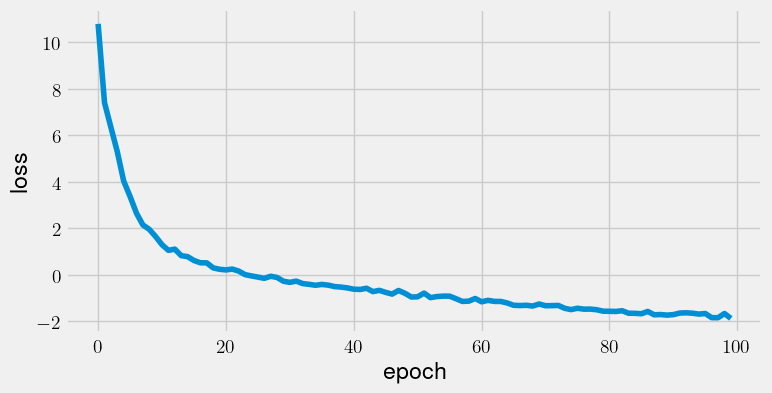

In [206]:
#Explicitly provided seeds for training process
random_seed = 12345  
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, batchsize = 5000, 400, 80

# sample parameter values from the specified prior
Theta_train = prior.sample((n_prior,))

# draw samples from the simulator conditioned on parameter values
Y_train = gaussian_mixture(Theta_train.unsqueeze(1), N=n_obs)

# put variances on log-scale & p on logit scale
Theta_train[...,0].logit_()
Theta_train[...,3:].log_()

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train.T, Theta_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)


#========================================================
#   Gaussian mixture net with data sorting
#========================================================
gmmnet = hf.MultivariateGaussianMDN(input_size=n_obs, dim=5, K=2, hd=128, sort=True).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=3e-4,
                       eps=0.1, 
                       max_epochs=100,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/gaussian_mixture/dmnet_sorted.pt'
                      )

### Posterior distribution

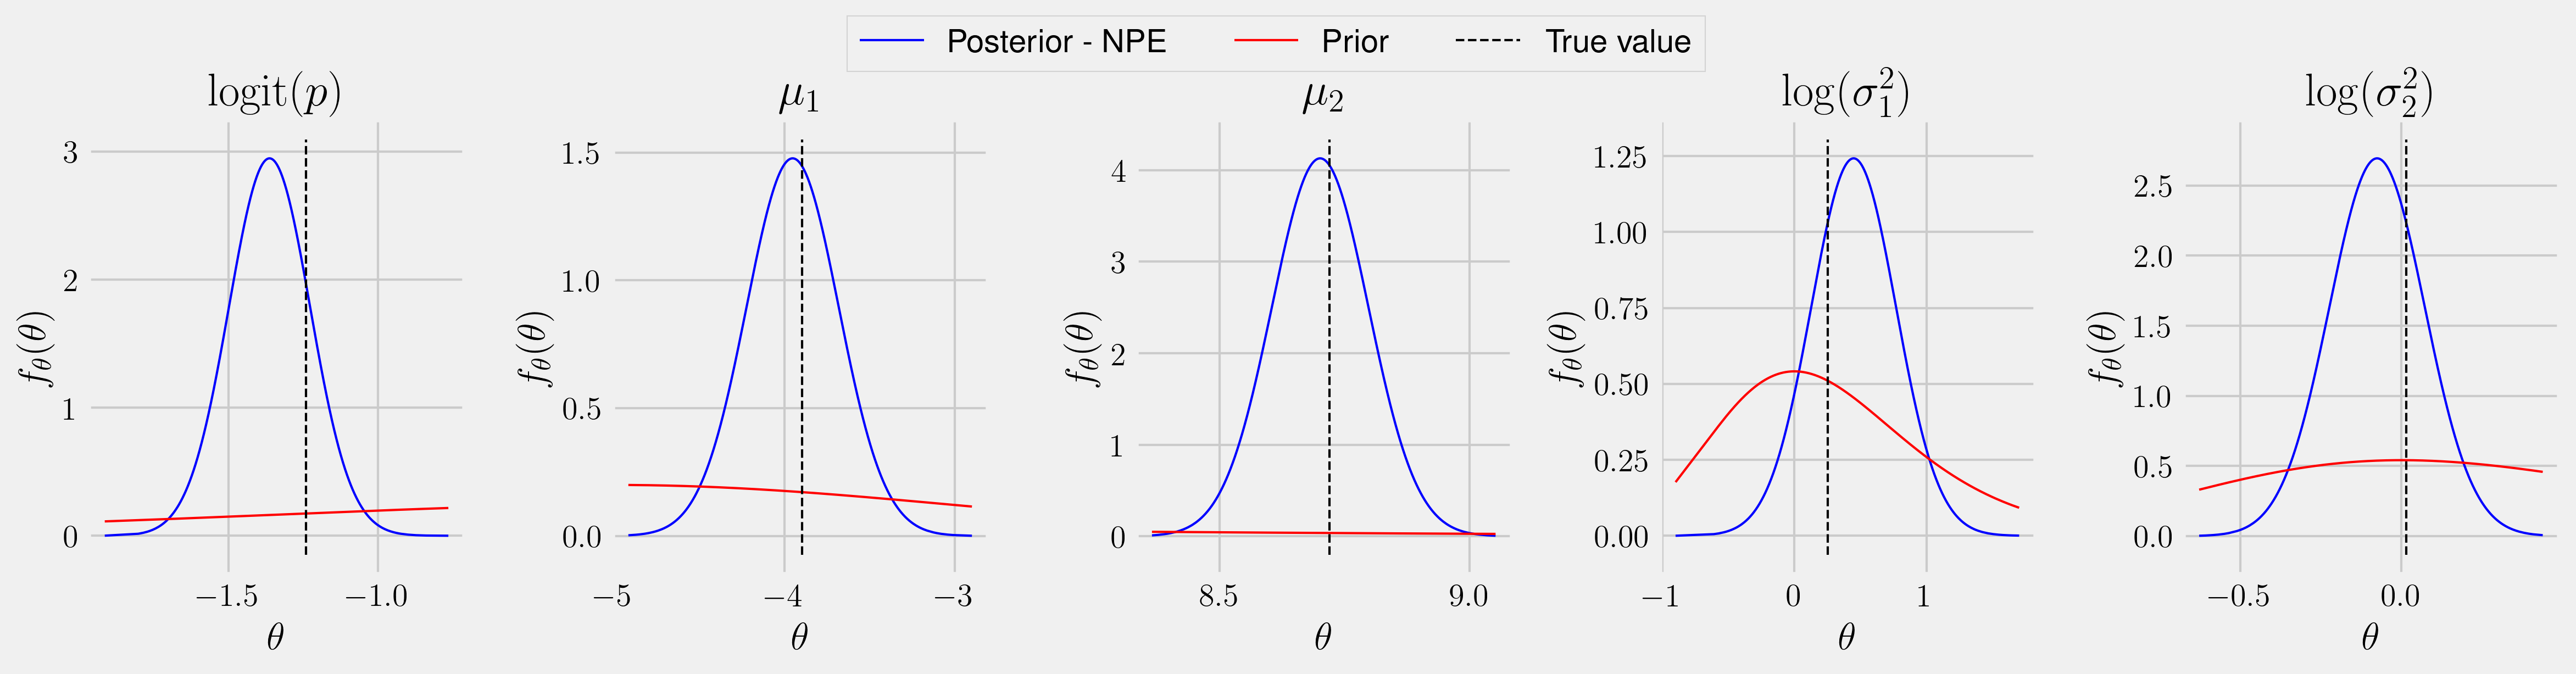

In [209]:
labels = [r'$\mathrm{logit}(p)$', r'$\mu_1$', r'$\mu_2$', r'$\log(\sigma_{1}^2)$', r'$\log(\sigma_{2}^2) $']

theta = prior.sample((1,))

y = gaussian_mixture(theta, n_obs).unsqueeze(0)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)

# plotting
fig = plt.figure(figsize=(16, 4), dpi=300)

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())

    # draw samples from the approximate posterior
    N = 10000
    theta_k = gmm.sample((N,)).squeeze().sort().values 
    pdf = gmm.log_prob(theta_k).exp().cpu()
    theta_k = theta_k.cpu()

    # prior
    if k == 0:
        theta_inv = theta_k.sigmoid()
        pdf_prior = prior.p.log_prob(theta_inv).exp() * abs(theta_inv * (1 - theta_inv))
    elif k == 1:
        pdf_prior = prior.mu1.log_prob(theta_k).exp()
    elif k == 2:
        pdf_prior = prior.mu2.log_prob(theta_k).exp()
    elif k == 3:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_1.log_prob(theta_inv).exp() * abs(theta_inv)
    else:
        theta_inv = theta_k.exp()
        pdf_prior = prior.sigma2_2.log_prob(theta_inv).exp() * abs(theta_inv)
   

    # true value    
    theta_k_true = theta[:,k].logit() if k == 0 else theta[:,k] if k < 3 else theta[:,k].log()
    
    fig.add_subplot(1, dim, k+1)
    plt.plot(theta_k, pdf, lw=1., c='b', label='Posterior - NPE')
    plt.plot(theta_k, pdf_prior, lw=1., c='r', label='Prior')
    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1, label='True value')
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$f_\theta(\theta)$')
    plt.title(labels[k])

handles, legend_labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=False)
fig.tight_layout()
plt.show()

fig.savefig(fname="figures/gaussian_mixture_2.png", transparent=True, bbox_inches='tight')

### Simulation-based calibration check

In [178]:
def sbc_gaussian(gmmnet, proposal, n_sim = 1e+4, ecdf=True, ecdf_diff=False, logscale=None,
                  labels=None, figsize=(12, 4), dpi=100):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''
    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta = proposal.sample((n_sim,))

    # draw samples from the model x ~ p(x|theta)
    X = gaussian_mixture(Theta.unsqueeze(1), n_obs).T

    # ensure all dimensions are on the right scale
    Theta[...,0].logit_()
    Theta[...,3:].log_()
    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 
    
    fig = plt.figure(figsize=figsize, dpi=dpi)

    for j in range(dim):
        # define GMM variational marginal distributions and calculate cdf values for the true parameter values

        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,j].squeeze(), torch.sqrt(covariance[:,:,j,j]).squeeze())
        # evaluate cdf
        w = gmm.cdf(Theta[:,j].to(device)).cpu().squeeze()

        if ecdf:
            #=====================================================
            # ECDF plot
            #=====================================================
            # Calculate the empirical cumulative distribution function (ECDF)
            eCDF = torch.arange(1, n_sim + 1) / n_sim

            # calculate 95% confidence intervals for the eCDF
            eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
            eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

            # exact cdf
            x = np.linspace(0, 1, 100)
            w = w.sort().values

            fig.add_subplot(1, dim, j+1)
            if not ecdf_diff:
                # plot eCDF and true CDF values
                plt.step(w, eCDF, lw=1)
                plt.plot(x, x, 'k--', lw=1)
                # plot 95% confidence bands
                plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)
                plt.ylabel(r'$F_{\omega}$')
            else:
                plt.step(w, eCDF - w, lw=1)
                #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
                plt.ylabel(r'$F_{\omega} - \omega$')

            plt.xlabel(r'$\omega$')
            plt.title(labels[j])
        else:
            #========================================
            # plot histograms
            #========================================
            fig.add_subplot(1, dim, j + 1)
            plt.hist(w, bins=25, density=True, alpha=.6)
            plt.title(labels[j])

    plt.tight_layout()
        
    
    return fig

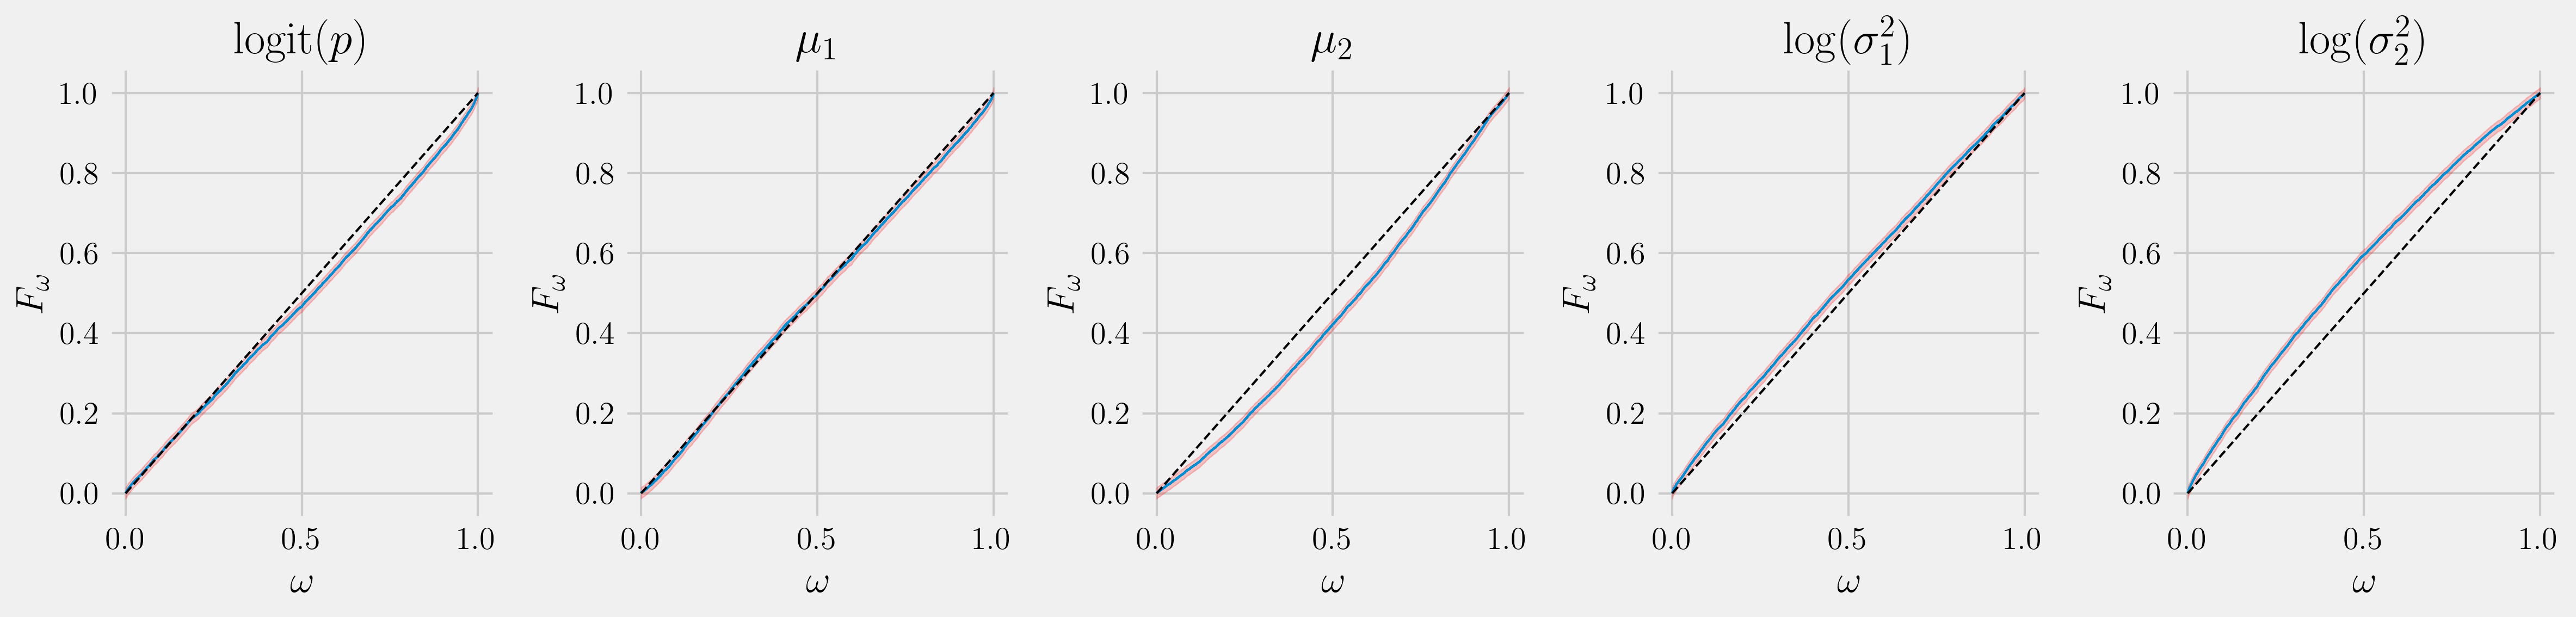

In [210]:
f = sbc_gaussian(gmmnet, prior, 10000, ecdf=True, ecdf_diff=False, labels=labels, dpi=300, figsize=(16, 4))
f.savefig(fname="figures/gaussian_mixture_sbc.png", transparent=True, bbox_inches='tight')